# Chip placement

Designing computer chips takes a lot of effort and time, and is virtually impossible without extremely advanced optimisation algorithms. One step in the design of chips is the *placement* problem: how to place the different modules of the chips onto the wafer so that a whole host of side constraints are satisfied and such that a number of optimisation goals are attained. In particular, placement should be done in such a way that, in a later step, all wire connections can be realised and such that these are, overall, short. A modern chip comprises many millions of modules. As a result it becomes infeasible to solve the placement problem directly -- instead a global / local approach is pursued: The modules are partitioned, *clustered*, into parts that are more tightly interlinked; for each such partition a part of the wafer is reserved. Afterwards the clusters itself are placed in their reserved area. As far as I understand, there's a bit of a back and forth: global placement is effectuated, followed by local placement, which in turn leads to tighter constraints to global placement and so on. 

Graph clustering can be used to partition the modules. We treat here a (smallish) dataset that was used for a [competition in 2005](https://www.ispd.cc/contests/05/contest.htm), organised by the [International Symposium on Physical Design](https://ispd.cc/ispd2024/index.php?page=contests). Why from 2005? Because the dataset is still of manageable size. 

The dataset is [here](http://www.ispd.cc/contests/05/ispd05-contest/adaptec1.tar.gz) but we'll download it below. The file <code>adaptec1.nets</code> basically describes a graph on the modules of the chip: Each module has an entry in the file that describes to which other modules it is linked by a wire connection. This piece of information is a *netlist*. [Here's](https://en.wikipedia.org/wiki/Netlist) a wikipedia article on *netlists*. More on the placement problem can also be found [here.](https://en.wikipedia.org/wiki/Placement_(electronic_design_automation))


In [1]:
import networkx as nx # the graph library
import matplotlib.pyplot as plt # plotting
import numpy as np
import scipy
import math

Next, let's download and unpack the data. As always if you're working on your own Windows machine -- I don't know, get a [proper OS](https://ubuntu.com/download/desktop), perhaps? If you're working in Colab, simply run the next cell.

In [12]:
# comment out if you've downloaded the data by hand
!wget -q --show-progress http://www.ispd.cc/contests/05/ispd05-contest/adaptec1.tar.gz
!tar -zxf adaptec1.tar.gz

adaptec1.tar.gz     100%[===================>]   4,68M  2,35MB/s    in 2,0s    


Let's have a peek at the file <code>adaptec1.nets</code>.

In [2]:
count=0
with open("adaptec1.nets") as f:
    for line in f:
        count+=1
        if count==20:
            break
        print(line,end="")
        #parse(line)

UCLA nets 1.0
# Created	:	Jan  6 2005
# User   	:	Gi-Joon Nam & Mehmet Yildiz at IBM Austin Research({gnam, mcan}@us.ibm.com)

NumNets : 221142
NumPins : 944053

NetDegree : 4   n0
	o197239	I : -0.500000	-6.000000
	o197110	O : -1.500000	-3.000000
	o85644	I : -6.000000	-2.000000
	o0	I : -3.000000	-5.000000
NetDegree : 2   n1
	o203752	O : -6.500000	2.000000
	o0	I : -4.000000	-5.000000
NetDegree : 2   n2
	o23	I : -14.500000	0.000000
	o0	O : 0.000000	-1.000000
NetDegree : 3   n3


To read in the graph, let's first collect all the module that need to be connected in a dictionary <code>edge_dict</code>.

In [3]:
with open("adaptec1.nets") as f:
    current_vertex=None
    edge_dict={}
    count=0
    for line in f:
        count+=1
        line_elements=line.strip().split()
        if len(line_elements)>0 and line_elements[0]=="NetDegree":
            current_vertex=line_elements[-1]
        elif current_vertex is not None:
            edge_name=line_elements[0]
            if edge_name in edge_dict:
                edge_dict[edge_name].append(current_vertex)
            else:
                edge_dict[edge_name]=[current_vertex]

Now we turn <code>edge_dict</code> into a graph. For this we need to add a clique for every entry in <code>edge_dict</code>.

In [4]:
G=nx.Graph()
for clique in edge_dict.values():
    for i,vx1 in enumerate(clique):
        for vx2 in clique[i+1:]:
            G.add_edge(vx1,vx2)


In [5]:
G.number_of_nodes(),G.number_of_edges()

(221142, 2666612)

<code>plt.spy</code> [here](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.spy.html)

https://github.com/alugowski/matspy

In [6]:
def right(old_size,new_size):
    num_rows=old_size
    num_cols=new_size
    mult=math.ceil(num_rows/num_cols)
    cols=[i for i in range(num_cols) for j in range(mult)][:num_rows]
    rows=range(num_rows)
    data=np.ones(num_rows)
    R=scipy.sparse.coo_matrix((data,(rows,cols)))
    return R

def left(old_size,new_size):
    return right(old_size,new_size).T

def reduce(matrix,new_size):
    # we assume a square matrix
    old_size=matrix.shape[0]
    scale_factor=old_size/new_size
    return (left(old_size,new_size)@matrix@right(old_size,new_size) / (scale_factor**2)).todense()

def spy(matrix,new_size=1000,scale_factor=1,ax=None,figdim=4):
    reduced_matrix=reduce(matrix,new_size)
    if ax is None:
        fig,ax=plt.subplots(figsize=(figdim,figdim))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(reduced_matrix*scale_factor,cmap='binary',vmin=0,vmax=1)
    return ax

spy(nx.adjacency_matrix(G),scale_factor=10000)

<Axes: >

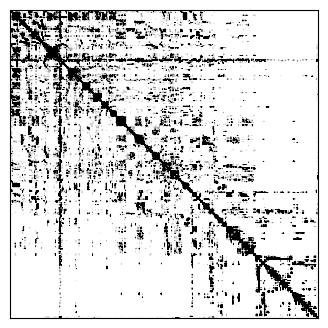

In [8]:
clusters=list(nx.community.louvain_communities(G,resolution=0.5))

In [9]:
def adjacency_matrix_by_clusters(G,clusters):
    node_mapper={name:i for i,name in enumerate(G.nodes)}
    new_order=[node_mapper[name] for cluster in clusters for name in cluster]
    A=nx.adjacency_matrix(G)
    reordered=((A[new_order]).T[new_order]).T
    return reordered

<Axes: >

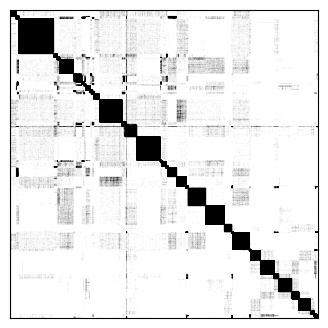

In [11]:
spy(adjacency_matrix_by_clusters(G,clusters),scale_factor=10000)